## Install Packages (Optional)
Creating a environment in Studio Lab is easy, just select the environment.yaml file (by cloning this repository or upload it directly), right click the YAML file and select create environment. Once the environment is created, you open this notebook with the newly created kernel. Optionally you can also uncomment the package installation section of the notebook to install these packages manually.

In [ ]:
# %pip install boto3
# %pip install pandas
# %pip install opencv-python
# %pip install matplotlib
# %pip install torch
# %pip install numpy
# %pip install s3fs
# %pip install seaborn

## Import Packages
After the environment is created and selected or the packages installed manually, we can import them directly.

In [1]:
# Import statements for packages used...
import io
import boto3
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from botocore import UNSIGNED
from botocore.config import Config
import cv2
import textwrap

from pathlib import Path
import random as r
from torch.utils.data import Dataset
from PIL.Image import Image

# S3 access

This notebook works with satellite imagery stored in S3.
The data is provided by [Radiant Earth](https://www.radiant.earth/) under the Creative Commons Attribution 4.0 International license, and hosted, for free, in Amazon S3 under the [Amazon Sustainability Data Initiative](https://sustainability.aboutamazon.com/environment/the-cloud/asdi) catalog.

The data was assembled for a competition to predict wind speeds; it's tailored for training a CNN. This notebook covers data exploration, and prepares the data for training and inference.

The training data consists of over 70,000 single-band images from storms in the Atlantic and East Pacific Oceans. The data come from a satellite band representing long-wave infrared frequency, which increases the brightness of clouds and should help us to better capture the spatial structure of storms. Each image has a corresponding wind speed contained in a separate file, measured in knots.

We'll also take a peek at the set of 44,000 unlabeled test images.

## We need an S3 client.
We can use this client throughout our notebook without an AWS account to get these free assets.

In [2]:
#create the client we'll use to work with S3
client = boto3.client('s3', config=Config(signature_version=UNSIGNED))

## Create a DataFrame for test images 

Paginate through the bucket looking for the jpeg files in the test directory.
This code shows how to use ***list_objects_v2*** to work with very large datasets.

It takes abbout 1 minute to paginate through the 44377 jpeg objects in the test set.

In [3]:
#filter for jpegs
def process_bucket_item(bucket_item):
    k = (bucket_item['Key'])
    if k.find('jpg') >= 0:
        test_paths.append([k])


def iterate_bucket_items(bucket, prefix):
    """
    Generator that iterates over all objects in a given s3 bucket

    See http://boto3.readthedocs.io/en/latest/reference/services/s3.html#S3.Client.list_objects_v2 
    for return data format
    :param bucket: name of s3 bucket
    :return: dict of metadata for an object
    """
    paginator = client.get_paginator('list_objects_v2')
    page_iterator = paginator.paginate(Bucket=bucket, Prefix=prefix)

    for page in page_iterator:
        if page['KeyCount'] > 0:
            for item in page['Contents']:
                yield item


wind_speed_bucket = 'radiant-mlhub'
#set the prefix for the test image collection
#change the prefix to 'nasa-tropical-storm-challenge/train'
#to build a DataFrame of training jpeg paths
wind_speed_prefix = f'nasa-tropical-storm-challenge/test'

test_paths = []

for i in iterate_bucket_items(bucket=wind_speed_bucket, prefix=wind_speed_prefix):
    process_bucket_item(i)

test_df = pd.DataFrame(
    np.array(test_paths),
    columns=['img']
)
print(test_df.shape)
test_df.head()

(44377, 1)


img
0  nasa-tropical-storm-challenge/test/acd_123.jpg
1  nasa-tropical-storm-challenge/test/acd_124.jpg
2  nasa-tropical-storm-challenge/test/acd_125.jpg
3  nasa-tropical-storm-challenge/test/acd_126.jpg
4  nasa-tropical-storm-challenge/test/acd_127.jpg

## Display a random test image


In [4]:
#create an image from the S3 path
#we process the colorspace to make a nice grayscale image
def renderImagePath(path):  
    obj = client.get_object(Bucket= 'radiant-mlhub' , Key = path)
    file_stream = obj['Body'].read()
    np_array = np.frombuffer(file_stream, np.uint8)
    image_np = cv2.imdecode(np_array, cv2.IMREAD_COLOR)
    gray = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)
    return gray

Run the next cell repeatedly to sample the test data.

*Note that all the images remain in S3. You haven't had to download any of them to your local environment.*

nasa-tropical-storm-challenge/test/yuo_019.jpg


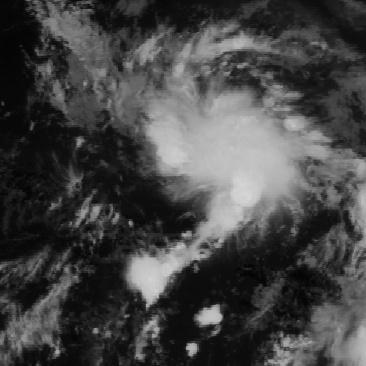

In [6]:
from PIL import Image

# display a random test image
# we'll use a helper function above to get the image. Later we'll show how to use 
# this technique in a custom class
#let's calculate the index

index = r.randrange(0, len(test_df))
print(test_df.iat[index,0])   #show the image path
Image.fromarray(renderImagePath(test_df.iat[index,0]))

## Create dataframes from metadata hosted in S3

Let's load the metadata from the S3 bucket. 
We can explore trends across oceans, storms, wind speeds, and relative time using the training metadata.
You don't need an AWS account to get this data.


This is a good dataset to explore because it's been labeled, and the features are all in csv files.

Much of this section is based on Tammy Glazer's excellent Radiant Hub example, [Benchmark - Wind-dependent Variables: Predict Wind Speeds of Tropical Storms](https://github.com/radiantearth/mlhub-tutorials/blob/main/notebooks/NASA%20Tropical%20Storm%20Wind%20Speed%20Challenge/nasa-tropical-storm-wind-speed-challenge-benchmark.ipynb)

It differs, however, in that the data is not pre-downloaded, but fetched from S3 as needed.

That's good because in serverless environments you may not have the time or storage to download all the artifacts in a dataset.

In [7]:
#Get the csv metadata objects from the s3 buckets where they're stored
#We'll create dataframes directly from the s3 objects without downloading them
obj = client.get_object(Bucket= 'radiant-mlhub' , Key = 'nasa-tropical-storm-challenge/training_set_labels.csv')

train_labels = pd.read_csv(io.BytesIO(obj['Body'].read()), encoding='utf8')
print(train_labels.shape)
train_labels.head(5)

(70257, 2)


Image ID  Wind Speed
0  nhe_000          34
1  nhe_001          34
2  nhe_002          34
3  nhe_003          33
4  nhe_004          32

## Storm data statistics

In [8]:
#Get the training set labels
#The labels contain wind speeds
obj = client.get_object(Bucket= 'radiant-mlhub' , Key = 'nasa-tropical-storm-challenge/training_set_features.csv')

train_metadata = pd.read_csv(io.BytesIO(obj['Body'].read()), encoding='utf8')
print(train_metadata.shape)
train_metadata.head(5)


(70257, 4)


Image ID Storm ID  Relative Time  Ocean
0  nhe_000      nhe              0      2
1  nhe_001      nhe           1800      2
2  nhe_002      nhe           3600      2
3  nhe_003      nhe           5402      2
4  nhe_004      nhe           9001      2

In [9]:
#How many storms are in the dataset?
train_metadata['Storm ID'].nunique()

494

In [10]:
#Describe the storms
storm_counts = train_metadata.groupby("Storm ID").size()
storm_counts.describe()

count    494.000000
mean     142.220648
std      123.151772
min        4.000000
25%       46.250000
50%      101.500000
75%      209.000000
max      648.000000
dtype: float64

How many images per storm?

In [11]:
#set a graphics default
pd.set_option("max_colwidth", 80)

Text(0.5, 1.0, 'Number of Images per Storm')

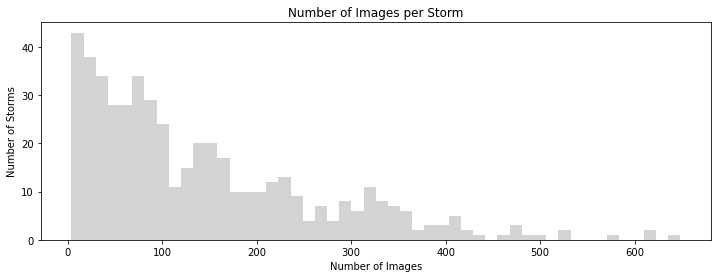

In [12]:
plt.figure(figsize=(12, 4))
plt.hist(storm_counts, bins=50, color="lightgray")
plt.xlabel("Number of Images")
plt.ylabel("Number of Storms")
plt.title("Number of Images per Storm")

Distribution of wind speeds?

Text(0.5, 1.0, 'Distribution of Wind Speeds')

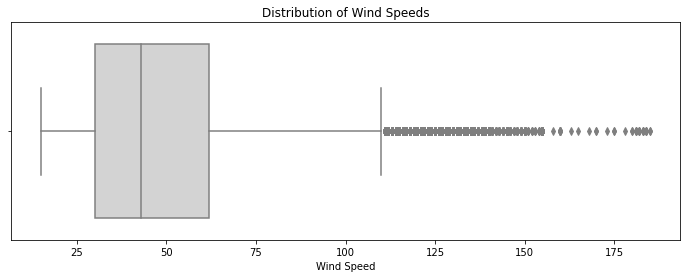

In [13]:
plt.figure(figsize=(12, 4))
sns.boxplot(x=train_labels['Wind Speed'], color="lightgray")
plt.xlabel("Wind Speed")
plt.title("Distribution of Wind Speeds")


## Combine training metadata and labels into one data set

In [14]:
# Merge train_metadata with train_labels on the image_id field
full_metadata = train_metadata.merge(train_labels, on="Image ID")
full_metadata.head()

Image ID Storm ID  Relative Time  Ocean  Wind Speed
0  nhe_000      nhe              0      2          34
1  nhe_001      nhe           1800      2          34
2  nhe_002      nhe           3600      2          34
3  nhe_003      nhe           5402      2          33
4  nhe_004      nhe           9001      2          32

In [15]:
def plot_wind_speeds(storm_id):
    storm = full_metadata[full_metadata['Storm ID'] == storm_id]
    plt.figure(figsize=(12, 4))
    plt.scatter("Relative Time", "Wind Speed", data=storm, color="lightgray")
    plt.ticklabel_format(useOffset=False)
    plt.ylabel("Wind Speed")
    plt.title(f"Wind Speed over Relative Time: Storm {storm_id}")



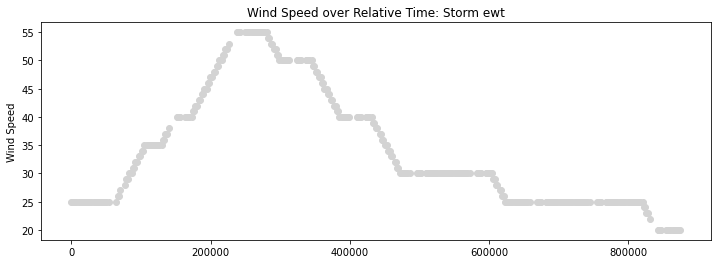

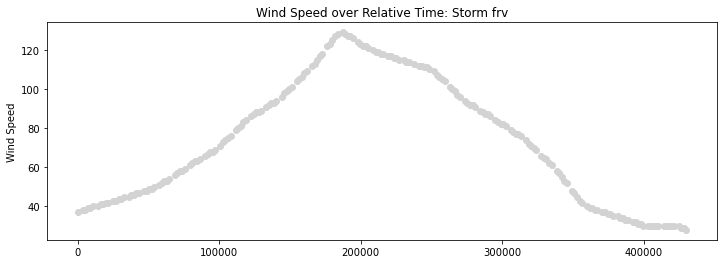

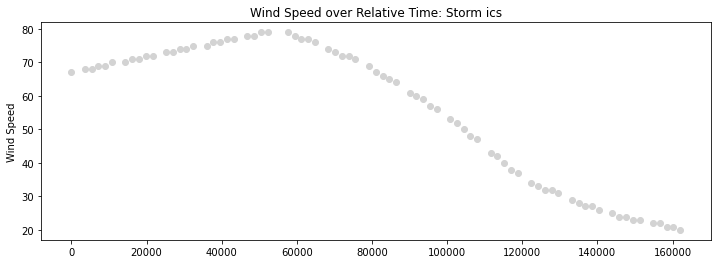

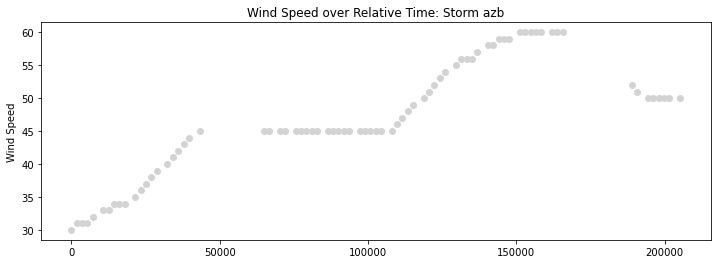

In [16]:
# Sample four random storms from full_metadata
for storm in full_metadata['Storm ID'].sample(4, random_state=40):
    plot_wind_speeds(storm)

In [17]:
#make a dataframe for a particular storm sequence
#we will see below how to add lazy S3 download functionality to this set
#when we create a custom class to work with this data
df = full_metadata[(full_metadata['Storm ID'].str.contains("ewt")) == True]
print(df.shape)
df.head()

(345, 5)


Image ID Storm ID  Relative Time  Ocean  Wind Speed
41621  ewt_000      ewt              0      1          25
41622  ewt_001      ewt           1799      1          25
41623  ewt_002      ewt           3600      1          25
41624  ewt_003      ewt           5399      1          25
41625  ewt_004      ewt           7200      1          25

In [18]:
#add the s3 path to the storm set
df2=df.assign(img=lambda x: "s3://radiant-mlhub/train/"+ x['Image ID'] + ".jpg")
df2.head()

Image ID Storm ID  Relative Time  Ocean  Wind Speed  \
41621  ewt_000      ewt              0      1          25   
41622  ewt_001      ewt           1799      1          25   
41623  ewt_002      ewt           3600      1          25   
41624  ewt_003      ewt           5399      1          25   
41625  ewt_004      ewt           7200      1          25   

                                        img  
41621  s3://radiant-mlhub/train/ewt_000.jpg  
41622  s3://radiant-mlhub/train/ewt_001.jpg  
41623  s3://radiant-mlhub/train/ewt_002.jpg  
41624  s3://radiant-mlhub/train/ewt_003.jpg  
41625  s3://radiant-mlhub/train/ewt_004.jpg

This is all great, but we don't have a good way to access the images in the dataset except to iterate through the S3 paths and manually download them.

Custom Dataset to the rescue.

# Create a custom Dataset 

## ***WindSpeedImageDataset*** 

This class provides a constructor that accepts a storm id, so you can make storm-specific sets of imagery.
The class won't download the images until they're needed.
There are also convenience methods for exporting storm images useful for visualizations (see below).

You can also use this DataSet in a Machine Learning workflow (not covered in this notebook.)

To implement the class we need three methods:
- **init**
    
    Create the class's internal dataframes.

- **len**

    Return the length of this dataset, so len(dataset) returns the proper size.

- **getitem**

    Download an image from S3 when the dataset object is accessed; also supports indexing so you can use dataset[i] to get iith sample.

In [19]:
class WindSpeedImageDataset(Dataset):
    
    def __init__(self,storm_id="all",transform=None):
        obj = client.get_object(Bucket= 'radiant-mlhub' , Key = 'nasa-tropical-storm-challenge/training_set_labels.csv')
        train_labels = pd.read_csv(io.BytesIO(obj['Body'].read()), encoding='utf8')
        obj = client.get_object(Bucket= 'radiant-mlhub' , Key = 'nasa-tropical-storm-challenge/training_set_features.csv')
        if(storm_id != "all"):
            train_metadata = pd.read_csv(io.BytesIO(obj['Body'].read()), encoding='utf8').query(str("`Storm ID` ==  \""+ storm_id + "\""))
        else:
            train_metadata = pd.read_csv(io.BytesIO(obj['Body'].read()), encoding='utf8')
        merged_df = train_metadata.merge(train_labels, on="Image ID")
        #add the s3 path to the storm set image to each row
        self.full_metadata= merged_df.assign(img=lambda x: "nasa-tropical-storm-challenge/train/"+ x['Image ID'] + ".jpg")
        self.transform = transform

    def __len__(self):
        return len(self.full_metadata)

    def __getitem__(self, idx):
        image_id   = self.full_metadata.iloc[idx, 0]
        storm_id   = self.full_metadata.iloc[idx, 1]
        rel_time   = self.full_metadata.iloc[idx, 2]
        ocean      = self.full_metadata.iloc[idx, 3]
        wind_speed = self.full_metadata.iloc[idx, 4]
        img_name   = self.full_metadata.iloc[idx, 5]
        image = self.renderImagePath(img_name)
 
        sample = {'image': image, 'Image ID':image_id, 'Storm ID':storm_id,	'Relative Time':rel_time, 'Ocean':ocean, 'Wind Speed':wind_speed }

        if self.transform:
            sample = self.transform(sample)

        return sample

    def getDataFrame(self):
        return self.full_metadata

    #create an image from the S3 path
    def renderImagePath(self,path):  
        obj = client.get_object(Bucket= 'radiant-mlhub' , Key = path)
        file_stream = obj['Body'].read()
        np_array = np.frombuffer(file_stream, np.uint8)
        image_np = cv2.imdecode(np_array, cv2.IMREAD_COLOR)
        gray = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)
        return gray
       
    #export an array of images
    #this uses the 'img' column created by the class ctor 
    def getImagePathArray(self):
        images_column = self.full_metadata['img']
        images_df = images_column.copy()
        # Applying a user defined function
        # to each row that will download the image into the dataframe
        images_df = images_df.apply( lambda row : self.renderImagePath(row) )
        return images_df


## Use our new Dataset to display satellite images from the training set

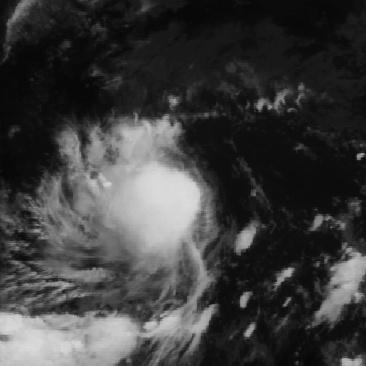

In [20]:
#one-line dataset creation and reference where you specify the storm and index
Image.fromarray(WindSpeedImageDataset("ewt")[45]['image'])


{'image': array([[11, 11, 12, ..., 18, 19, 19],
       [11, 12, 12, ..., 17, 16, 15],
       [12, 12, 13, ..., 19, 17, 16],
       ...,
       [46, 46, 60, ...,  6,  6,  6],
       [33, 38, 57, ...,  6,  6,  6],
       [29, 36, 58, ...,  6,  6,  6]], dtype=uint8), 'Image ID': 'alq_056', 'Storm ID': 'alq', 'Relative Time': 120601, 'Ocean': 1, 'Wind Speed': 30}


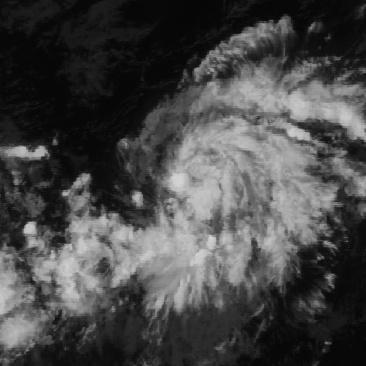

In [21]:
#this cell also prints the object from the custom data set
#make it random for fun
storm_dataset= WindSpeedImageDataset("alq")
sample= storm_dataset[r.randrange(0, len(storm_dataset))]
print(sample)
Image.fromarray(sample['image'])

# Make storm grids
The function display_images_from_dataset takes an instance of our custom dataset and lays it out in a grid.
Smaller values for max_images will yield faster results since our custom ***WindSpeedImageDataset*** only downloads images when they are needed for display.

*You'll notice that the training set images are much more uniform than the test images.*

In [22]:
#https://github.com/KeesCBakker/blogs/blob/master/plotting-a-grid-of-pil-images-in-jupyter/main.ipynb

import matplotlib.pyplot as plt
from PIL.Image import Image as PilImage
import textwrap, os
import numpy as np

def display_images_from_dataset(
    images_dataset,
    columns=5, width=30, height=6, max_images=500, 
    label_wrap_length=30, label_font_size=12):

    print(f"Showing {min(max_images, len(images_dataset))} images of {len(images_dataset)}:")

    height = max(height, int(len(images_dataset)/columns) * height)

    # create the plots
    fig = plt.figure(figsize=(width, height))
    for i, image in enumerate(images_dataset):
        if(i== max_images): break
        plt.subplot(int(len(images_dataset) / columns + 1), columns, i + 1)
        plt.imshow(cv2.cvtColor(image['image'],cv2.COLOR_BGR2RGB))
        ax = plt.gca()
        ax.axes.xaxis.set_major_locator(plt.NullLocator())
        ax.axes.yaxis.set_major_locator(plt.NullLocator())
        title = "Storm: "+ str(image['Storm ID']) + " Wind Speed: "+ str(image['Wind Speed']) 
        title=textwrap.wrap(title, label_wrap_length)
        title="\n".join(title)
        plt.title(title, fontsize=label_font_size); 
    

Showing 10 images of 345:


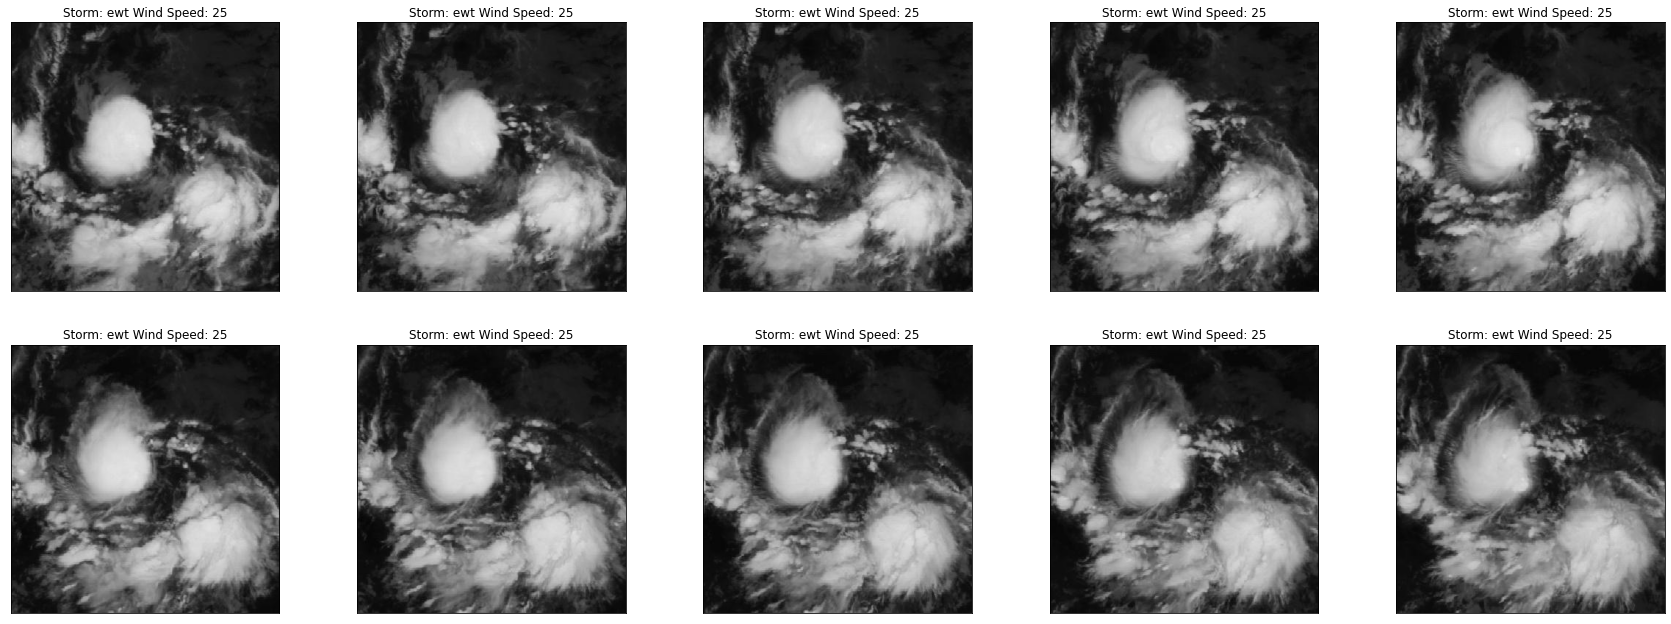

In [23]:
display_images_from_dataset(WindSpeedImageDataset("ewt"), max_images=10)

Showing 50 images of 293:


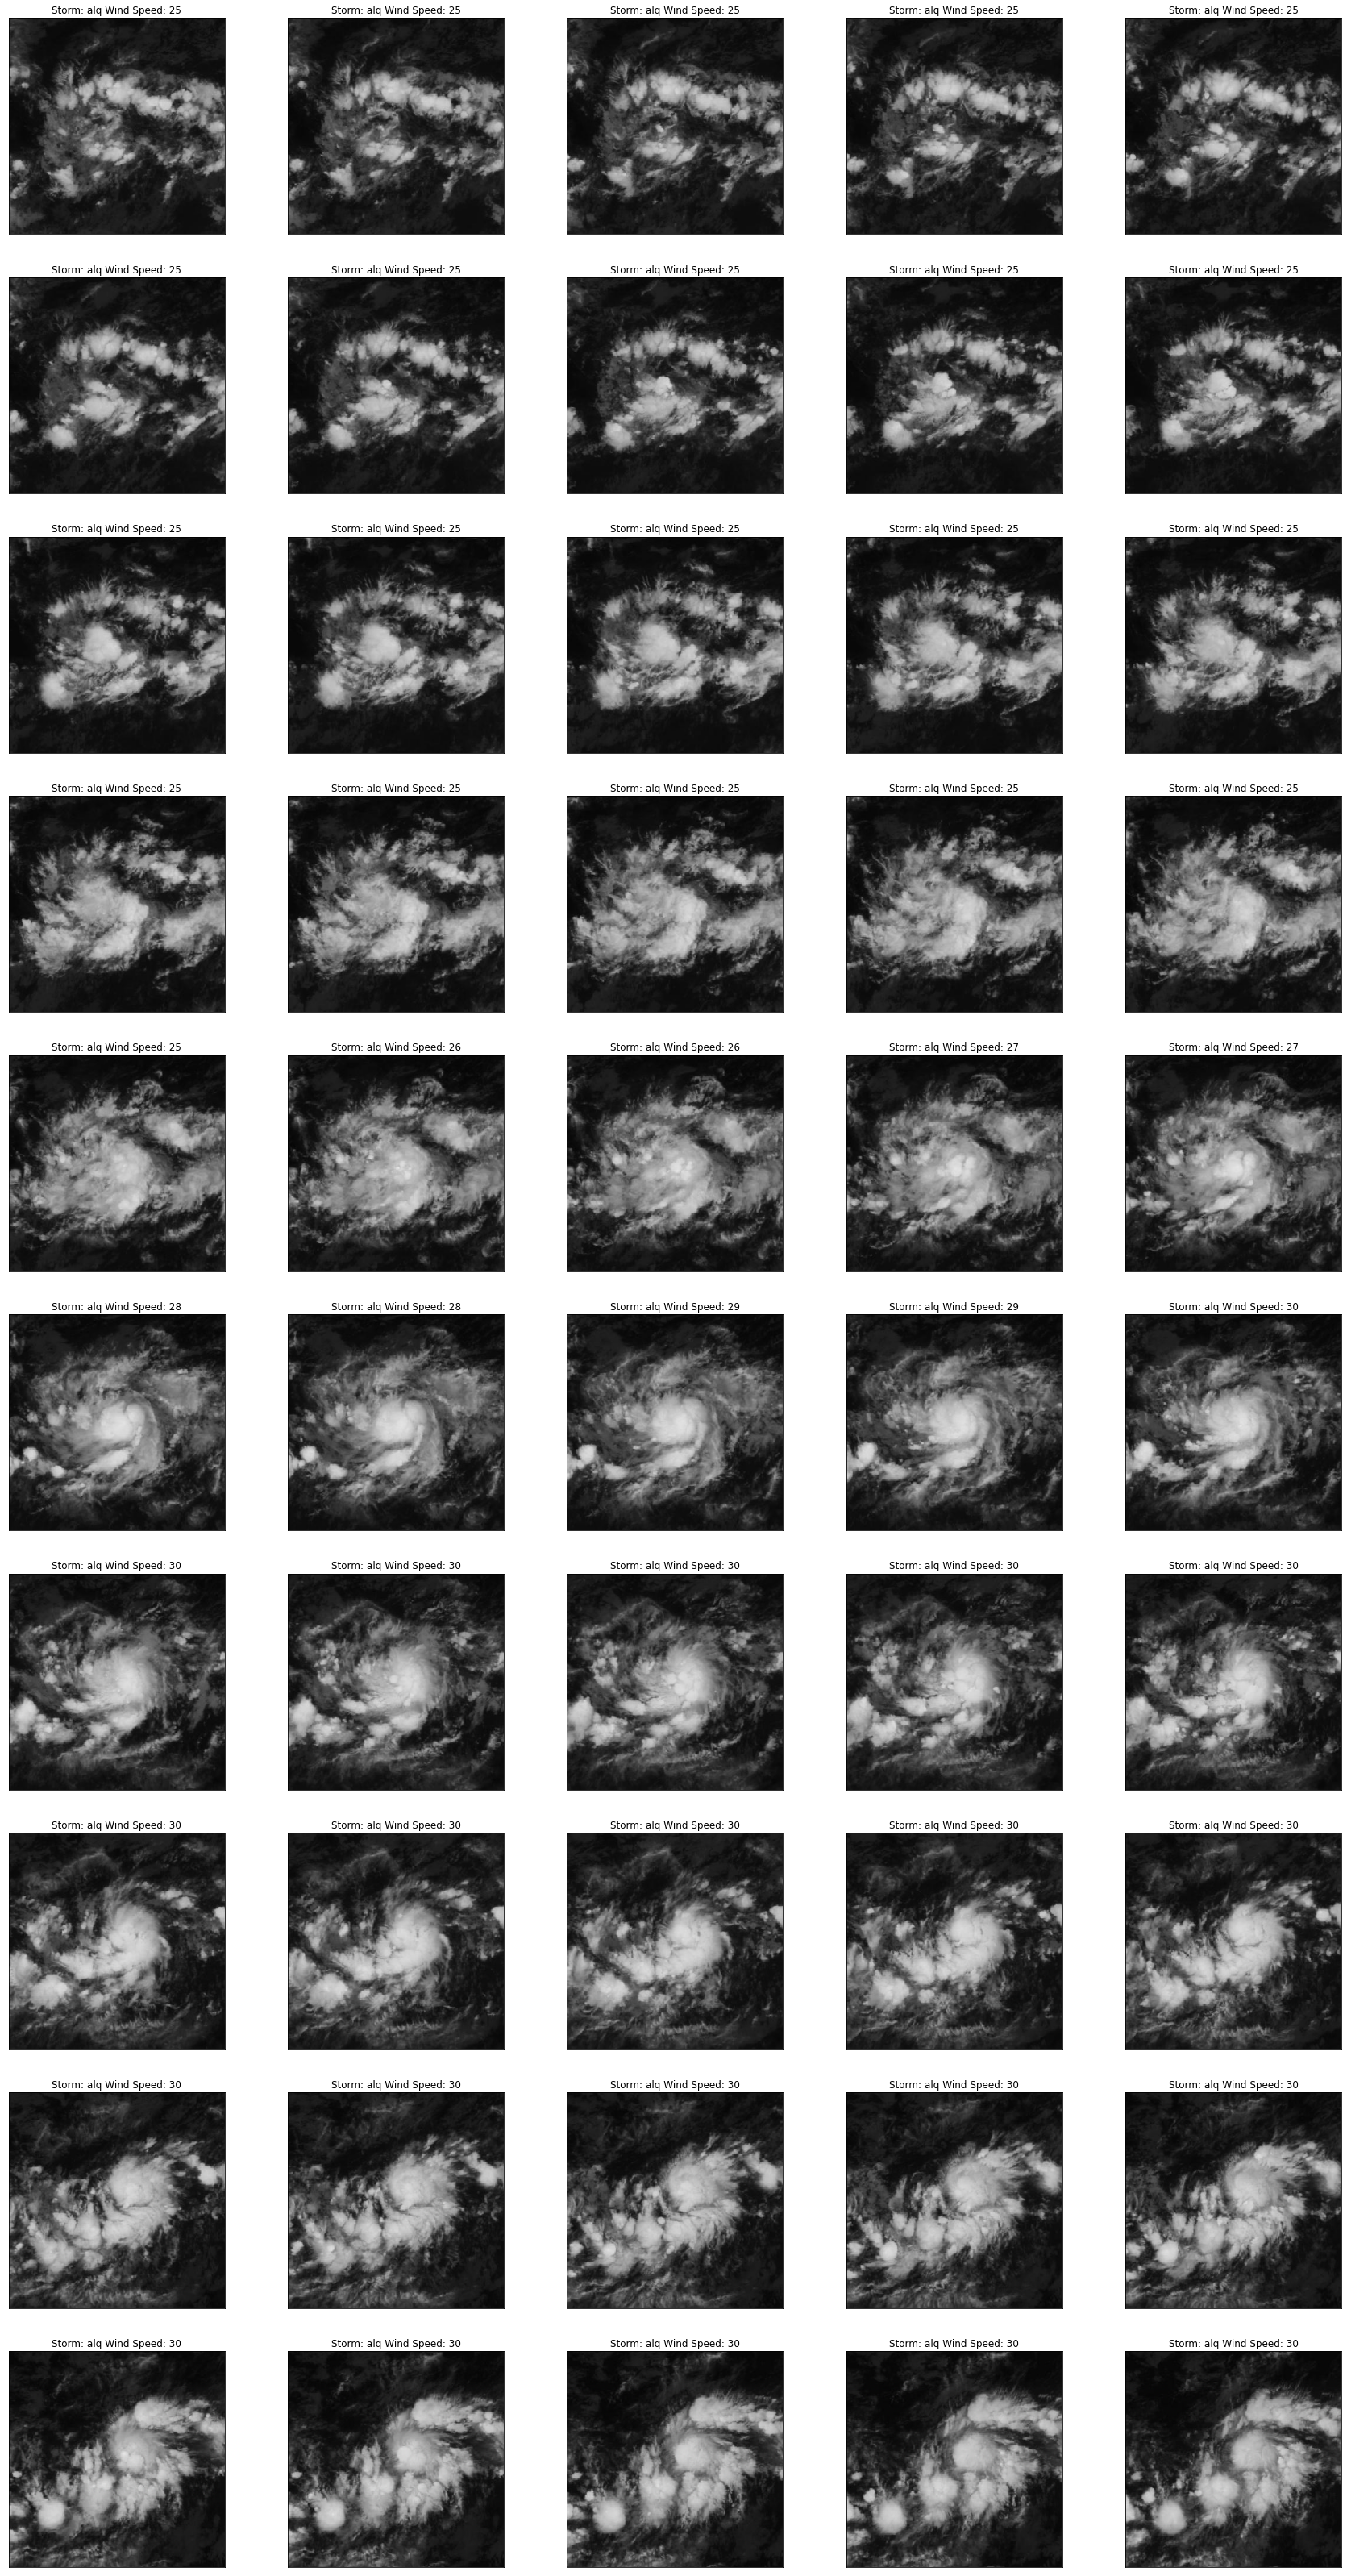

In [24]:
display_images_from_dataset(WindSpeedImageDataset("alq"), max_images=50)

# Animate storms from the dataset
This cell creates a storm-specific DataSet using our custom class, and uses matplotlib's animation package play its images in sequence.
Run the cell to build the animation. It may take a minute.
Then run the cell below to play the animation in the notebook.



In [25]:
import matplotlib.animation as animation

#get our storm
storm_set = WindSpeedImageDataset("frv")
#create our animation figure
fig, ax = plt.subplots()
ax.axes.xaxis.set_major_locator(plt.NullLocator())
ax.axes.yaxis.set_major_locator(plt.NullLocator())

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(max(60,len(storm_set))):  #cap at 60 frames; on environments with a lot of resources, you can do more
    image_sample = storm_set[i]
    wind_image = cv2.cvtColor(image_sample['image'],cv2.COLOR_BGR2RGB)
    im = ax.imshow(wind_image, animated=True)
    if i == 0:
        ax.imshow(wind_image)  # show an initial one first
    ims.append([im])

    
wind_ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
plt.close()

SageMaker Studio Lab doesn't support showing the animation inline, but you can save it as a file and open it in the UI.

If you are working in an environment that supports inline HTML, you can uncomment and use the HTML package to create an interactive animation embedded in the notebook.

In [26]:
#from IPython.display import HTML
#HTML(wind_ani.to_jshtml())

## Save your animation to a gif

You can save your animation to a gif.
If you download this notebook to a mac, the imagemagick library is required, and you can istall it with homebrew.

Uncomment the cells below to install imagemagick and save the animation.

In SageMaker Studio Lab you can use PillowWriter. The save will create a gif file in your home directory.

Open the resulting file to play your new animated gif.
Send it to everyone to demonstrate the fun you had exploring open data! 

In [27]:
# Mac OS
#!brew install imagemagick

In [28]:
# Mac OS
#wind_ani.save('animation.gif', writer='imagemagick', fps=60)

In [29]:
writergif = animation.PillowWriter(fps=30) 
wind_ani.save('animation.gif', writer=writergif)

# Next steps

Use the techniques in this notebook to access open data and prepare it for training your model.

There is a lot of helpful informatiuon about that in Tammy Glazer's Radiant Hub example, [Benchmark - Wind-dependent Variables: Predict Wind Speeds of Tropical Storms](https://github.com/radiantearth/mlhub-tutorials/blob/main/notebooks/NASA%20Tropical%20Storm%20Wind%20Speed%20Challenge/nasa-tropical-storm-wind-speed-challenge-benchmark.ipynb)